In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)

In [2]:
# LCDM background
h              = 0.6737
c              = 1
G              = 1
kappa          = 8*np.pi*G
a_today        = 1
Hprop_today    = (h*c)/2997.9
t_today_EdS    = 2/(3*Hprop_today)
Omega_m_today  = 0.3147
rho_flrw_today = (3*Omega_m_today*Hprop_today**2)/kappa
Omega_l_today  = 1 - Omega_m_today
Lambda         = Omega_l_today*3*(Hprop_today**2)/(c**2)
def a(t):
    return a_today*(Omega_m_today/Omega_l_today)**(1/3)*np.sinh(np.sqrt(Omega_l_today)*t/t_today_EdS)**(2/3)
def dta(t):
    return Hprop(t)*a(t)
def dtdta(t):
    return dta(t)*Hprop(t)+a(t)*dtHprop(t)#((Lambda/3)-(kappa*rho_flrw(t)/6))
def at(tau):
    return a_today*(Omega_m_today/Omega_l_today)**(1/3)*np.sinh(tau)**(2/3)
def dtaua(tau):
    return (2/3)*atau(tau)*np.cosh(tau)/np.sinh(tau)
def Hprop(t):
    return Hprop_today * np.sqrt( Omega_m_today/((a(t)/a_today)**3) + Omega_l_today )
def dtHprop(t):
    return -3*Omega_m_today*dta(t)*(a_today**3)*(a(t)**(-4))*(Hprop_today**2)/(2*Hprop(t))
def Omega_m(t):
    return Omega_m_today / ( Omega_m_today + Omega_l_today*((a(t)/a_today)**3) )
def rho_flrw(t):
    return rho_flrw_today/a(t)**3

In [3]:
allNs = list(np.arange(8, 150, 4))
meanerror_3R = []
meanerror_B2 = []
meanerror_BT = []
meanerror_E2 = []
meanerror_ET = []
for N in allNs:
    L = 20
    dx = L/N
    FD = FD_file.FD_Class(dx, periodic_boundary=False)
    xyz = np.arange(-L/2, L/2, dx)[:N]
    xyz = xyz.astype('float128')
    x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
    Box_zero = np.zeros([N, N, N])
    Box_ones = np.ones([N, N, N])
    loc = int(N/2), int(N/2), int(N/2)
    
    t = 1.5
    Amp = 1000
    k = 2*np.pi/L
    tauC = np.sqrt(3*Lambda/4)
    betaP = Amp*(1-np.sin(k*z))
    dzbetaP = -k*Amp*np.cos(k*z)
    betaM = 0
    B = (3/4)*(Hprop_today**2)*(Omega_l_today*(Omega_m_today**2))**(1/3)
    A = 1+B*betaP*(x**2+y**2)

    tau = tauC*t
    fM = np.cosh(tau)/np.sinh(tau)
    hyperthing = sc.hyp2f1(5/6, 3/2, 11/6, -np.sinh(tau)**2) 
    integrated_part = (3/5)*np.sqrt(np.cosh(tau)**2)*hyperthing*(np.sinh(tau)**(5/3))/np.cosh(tau)
    fP = fM*integrated_part
    dtaufM = -1/np.sinh(tau)**2
    dtfM = tauC*dtaufM
    part_to_integrate = (np.sinh(tau)**(2/3))/np.cosh(tau)**2
    dtaufP = dtaufM*integrated_part+fM*part_to_integrate
    dtfP = tauC*dtaufP
    dtaudtaufM = 2*np.cosh(tau)/np.sinh(tau)**3
    dtdtfM = (tauC**2)*dtaudtaufM
    dtau_part_to_integrate = (2/3)*(np.sinh(tau)**(-1/3))*(np.cosh(tau)**(-1))-2*(np.sinh(tau)**(5/3))*(np.cosh(tau)**(-3))
    dtaudtaufP = dtaudtaufM*integrated_part+2*dtaufM*part_to_integrate+fM*dtau_part_to_integrate
    dtdtfP = (tauC**2)*dtaudtaufP

    F     = betaM*fM + betaP*fP
    dzF   = dzbetaP*fP
    Z     = F + A
    dxZ   = 2*B*betaP*x
    dxdxZ = 2*B*betaP
    dyZ   = 2*B*betaP*y
    dydyZ = 2*B*betaP
    dzZ   = dzF + B*dzbetaP*(x**2+y**2)
    dtZ   = betaM*dtfM + betaP*dtfP
    dtdtZ = betaM*dtdtfM + betaP*dtdtfP

    delta =  -F/Z
    rho =  rho_flrw(t)*(1+delta)

    gdown = (a(t)**2)*np.array([[Box_ones, Box_zero, Box_zero],
                                [Box_zero, Box_ones, Box_zero],
                                [Box_zero, Box_zero, Z**2]])
    gdown4 = np.array([[-Box_ones, Box_zero, Box_zero, Box_zero],
                       [Box_zero, gdown[0,0], gdown[0,1], gdown[0,2]],
                       [Box_zero, gdown[1,0], gdown[1,1], gdown[1,2]],
                       [Box_zero, gdown[2,0], gdown[2,1], gdown[2,2]]])
    nup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])

    Kdown = -(a(t)**2)*np.array([[Box_ones*Hprop(t), Box_zero,          Box_zero],
                                 [Box_zero,          Box_ones*Hprop(t), Box_zero],
                                 [Box_zero,          Box_zero,          (Z**2)*(Hprop(t)+dtZ/Z)]])
    
    glist = [gdown[0,0], gdown[0,1], gdown[0,2], gdown[1,1], gdown[1,2], gdown[2,2]]
    gdet = RRead.det(glist)
    gup = RRead.inv(glist, gdet)
    RCW = RCW_file.Ricci_CoGrad_Weyl_Class(dx, periodic_boundary=False)
    Gudd = RCW.Christoffel_symbol(gdown, gup)
    RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)
    
    RicciS3th = -2*(dxdxZ+dydyZ)/(a(t)*a(t)*Z)
    meanerror_3R += [np.mean(np.ma.masked_invalid(abs(RicciS3/RicciS3th-1)))]
    
    
    udown = np.array([-Box_ones, Box_zero, Box_zero, Box_zero])
    Tdown4 = rho*np.einsum('a...,b...->ab...',udown,udown)
    Bdict = RCW.Weyl_B(gdown4, nup, gdown, gup, Gudd, Kdown)
    meanerror_B2 += [np.mean(np.ma.masked_invalid(abs(Bdict['B2'])))]
    meanerror_BT += [np.mean(np.ma.masked_invalid(abs(Bdict['Btrace'])))]
    
    Edict = RCW.Weyl_E(gdown, gup, RicciS3, RicciTdown, Kdown, kappa, rho, Lambda, Tdown4[1:,1:])
    E2th = ((dydyZ**2)-dxdxZ*dydyZ+(dxdxZ**2)+(a(t)**2)*((dta(t)*dtZ+a(t)*dtdtZ)**2)+a(t)*(dxdxZ+dydyZ)*(dta(t)*dtZ+a(t)*dtdtZ))/(6*(a(t)**4)*(Z**2))
    meanerror_E2 += [np.mean(np.ma.masked_invalid(abs(Edict['E2']/E2th-1)))]
    meanerror_ET += [np.mean(np.ma.masked_invalid(abs(Edict['Etrace'])))]
    del Edict
    print('N={}, error={:.2e} | {:.2e}, {:.2e} | {:.2e}, {:.2e}'.format(N, meanerror_3R[-1], meanerror_B2[-1], meanerror_BT[-1], meanerror_E2[-1], meanerror_ET[-1]))
    

/opt/apps/pkgs/cpython/3.7.1/intel64/intel_2019.2/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide
/opt/apps/pkgs/cpython/3.7.1/intel64/intel_2019.2/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in true_divide


N=8, error=3.21e-09 | 3.27e-21, 0.00e+00 | 2.14e-08, 2.38e-17
N=12, error=4.59e-10 | 1.94e-22, 0.00e+00 | 3.06e-09, 2.37e-17
N=16, error=1.20e-10 | 2.06e-23, 0.00e+00 | 7.97e-10, 2.37e-17
N=20, error=4.30e-11 | 3.35e-24, 0.00e+00 | 2.86e-10, 2.37e-17
N=24, error=1.88e-11 | 7.33e-25, 0.00e+00 | 1.25e-10, 2.37e-17
N=28, error=9.45e-12 | 2.00e-25, 0.00e+00 | 6.30e-11, 2.37e-17
N=32, error=5.25e-12 | 6.41e-26, 0.00e+00 | 3.49e-11, 2.37e-17
N=36, error=3.15e-12 | 2.34e-26, 0.00e+00 | 2.09e-11, 2.37e-17
N=40, error=2.02e-12 | 9.45e-27, 0.00e+00 | 1.33e-11, 2.37e-17
N=44, error=1.39e-12 | 4.15e-27, 0.00e+00 | 8.88e-12, 2.37e-17
N=48, error=1.02e-12 | 1.96e-27, 0.00e+00 | 6.27e-12, 2.37e-17
N=52, error=7.69e-13 | 9.79e-28, 0.00e+00 | 4.73e-12, 2.37e-17
N=56, error=6.41e-13 | 5.15e-28, 0.00e+00 | 3.66e-12, 2.37e-17
N=60, error=5.57e-13 | 2.83e-28, 0.00e+00 | 3.04e-12, 2.37e-17
N=64, error=5.11e-13 | 1.61e-28, 0.00e+00 | 2.53e-12, 2.37e-17
N=68, error=4.78e-13 | 9.53e-29, 0.00e+00 | 2.28e-12, 2.

<IPython.core.display.Javascript object>


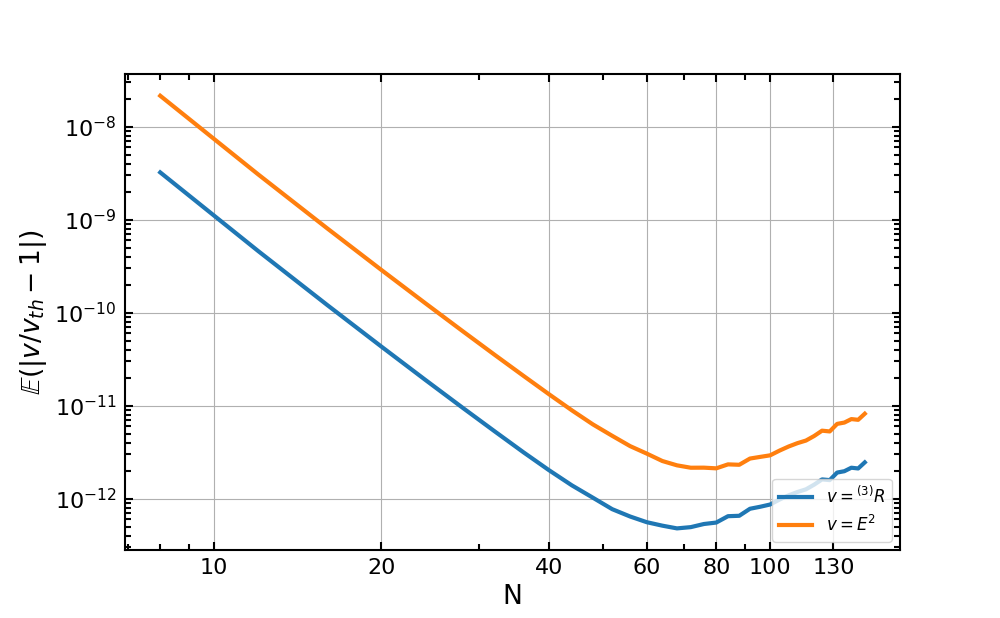

Text(0, 0.5, '$\\mathbb{E}\\left(|v/v_{th}-1|\\right)$')

In [6]:
idec = 0
iinc = -1


phi = (1+np.sqrt(5))/2
plt.figure(figsize=(10,10/phi))
plt.loglog(allNs[:len(meanerror_3R)], meanerror_3R, label=r'$v={}^{(3)}R$')
#yplot_4th_order_decrease = [meanerror_3R[idec]*((allNs[idec]/N)**4) for N in allNs]
#yplot_4th_order_increase = [meanerror_3R[iinc]*((N/allNs[iinc])**2.5) for N in allNs]
#plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2)
#plt.loglog(allNs, yplot_4th_order_increase, 'C3--', linewidth=2)

plt.loglog(allNs[:len(meanerror_E2)], meanerror_E2, 'C1', label=r'$v=E^2$')
#yplot_4th_order_decrease = [meanerror_E2[idec]*((allNs[idec]/N)**4) for N in allNs]
#yplot_4th_order_increase = [meanerror_E2[iinc]*((N/allNs[iinc])**2.5) for N in allNs]
#plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2, label='Truncation error') #4th order increase
#plt.loglog(allNs, yplot_4th_order_increase, 'C3--', linewidth=2, label='Rounding error')   #2.75 order increase


#plt.loglog(allNs, meanerror_B2, 'C4', label=r'$v=B^2$')
#yplot_4th_order_decrease = [meanerror_B2[idec]*((allNs[idec]/N)**4) for N in allNs]
#plt.loglog(allNs, yplot_4th_order_decrease, 'C2--', linewidth=2, label='Truncation error')

plt.legend(loc=4, prop={'size': 12})
plt.grid()
plt.xlabel('N')
plt.xticks([10,20,40,60,80,100,130], ['10','20','40','60','80','100','130'])
plt.ylabel(r'$\mathbb{E}\left(|v/v_{th}-1|\right)$')
#plt.ylim(1e-11, 8e-8)
#plt.savefig('Plots/Szekeres_Slicing.pdf')

In [7]:
import pandas as pd
data = np.array([allNs, meanerror_3R, meanerror_B2, meanerror_BT, meanerror_E2, meanerror_ET]).T
columns = ['N', '3R', 'B2', 'BT', 'E2', 'ET']
pd.DataFrame(data, columns=columns).to_csv('ErrorData/Szekeres_Slicing_128bit.csv')